In [ ]:
import pandas as pd

# Load the uploaded CSV file
file_path = 'validation_results_llama_4X.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the structure
df.head()


In [ ]:
import ast

# Reload the file using the correct delimiter
df = pd.read_csv(file_path, delimiter=';')

# Define the result columns we are interested in
result_columns = ['VL', 'pre_post_', 'pre', 'post', 'pre_VL_post', 'pre_VL', 'VL_post']

# Function to safely convert string to dictionary
def parse_result_column(value):
    try:
        return ast.literal_eval(value)
    except Exception:
        return {}

# Apply parsing to each result column
for col in result_columns:
    df[col] = df[col].apply(parse_result_column)

# Extract metrics
summary = {
    "Strategy": [],
    "Sanity_Test_Success": [],
    "Exploit_Covered": []
}

for col in result_columns:
    sanity_success = sum(1 for x in df[col] if x.get('Sanity_Test_Success') is True)
    exploit_covered = sum(1 for x in df[col] if x.get('Exploit_Covered') is True)
    summary["Strategy"].append(col)
    summary["Sanity_Test_Success"].append(sanity_success)
    summary["Exploit_Covered"].append(exploit_covered)

summary_df = pd.DataFrame(summary)

summary_df

In [ ]:
# Add a new column for patches that passed both criteria
accepted_patch_counts = []

for col in result_columns:
    count = sum(
        1 for x in df[col]
        if x.get('Sanity_Test_Success') is True and x.get('Exploit_Covered') is True
    )
    accepted_patch_counts.append(count)

# Add the new column to the summary DataFrame
summary_df['Accepted_Patch'] = accepted_patch_counts

summary_df

In [ ]:
pip install seaborn

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by Accepted_Patch descending
summary_df_sorted = summary_df.sort_values(by='Accepted_Patch', ascending=False).reset_index(drop=True)

# Bar chart settings
bar_width = 0.25
x = np.arange(len(summary_df_sorted))

# Define bar values
sanity_vals = summary_df_sorted["Sanity_Test_Success"]
exploit_vals = summary_df_sorted["Exploit_Covered"]
accepted_vals = summary_df_sorted["Accepted_Patch"]

# Patterns for accessibility
patterns = ["", "//", "xx"]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars
bars1 = ax.bar(x - bar_width, sanity_vals, width=bar_width, label='Sanity Test Success', hatch=patterns[0], color='gray')
bars2 = ax.bar(x, exploit_vals, width=bar_width, label='Exploit Covered', hatch=patterns[1], color='dimgray')
bars3 = ax.bar(x + bar_width, accepted_vals, width=bar_width, label='Accepted Patch', hatch=patterns[2], color='lightgray')

# Add numbers on top of bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

annotate_bars(bars1)
annotate_bars(bars2)
annotate_bars(bars3)

# Customize plot
ax.set_xlabel("Patch Strategy", fontsize=12)
ax.set_ylabel("Number of Cases", fontsize=12)
ax.set_title("Patch Strategy Effectiveness", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(summary_df_sorted["Strategy"])
ax.legend()
ax.set_facecolor('white')  # No background

plt.tight_layout()
plt.show()


In [ ]:
# Refined visualization with shades of green and blue, no grid, clean background

# Define new color scheme
colors = ['#a6d854', '#66c2a5', '#8da0cb']  # Green, Teal, Blue shades

# Re-plot with cleaner aesthetic and refined colors
fig, ax = plt.subplots(figsize=(10, 6))

# Recreate bars with patterns and soft colors
bars1 = ax.bar(x - bar_width, sanity_vals, width=bar_width, label='Sanity Test Success', hatch=patterns[0], color=colors[0])
bars2 = ax.bar(x, exploit_vals, width=bar_width, label='Exploit Covered', hatch=patterns[1], color=colors[1])
bars3 = ax.bar(x + bar_width, accepted_vals, width=bar_width, label='Accepted Patch', hatch=patterns[2], color=colors[2])

# Add number annotations
annotate_bars(bars1)
annotate_bars(bars2)
annotate_bars(bars3)

# Axis settings
ax.set_xlabel("Patch Strategy", fontsize=12)
ax.set_ylabel("Number of Cases", fontsize=12)
ax.set_title("Patch Strategy Effectiveness", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(summary_df_sorted["Strategy"])
ax.legend()

# Remove background grid and make face white
ax.set_facecolor('white')
ax.grid(False)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# Load the CSV file with semicolon delimiter
file_path = 'validation_results_llama_4X.csv'  # adjust if necessary
df = pd.read_csv(file_path, delimiter=';')

# Define the strategy columns
result_columns = ['VL', 'pre_post_', 'pre', 'post', 'pre_VL_post', 'pre_VL', 'VL_post']

# Safely parse stringified dictionaries
def parse_result_column(value):
    try:
        return ast.literal_eval(value)
    except Exception:
        return {}

for col in result_columns:
    df[col] = df[col].apply(parse_result_column)

# Extract metrics into a long-form list of records
records = []
for _, row in df.iterrows():
    vuln_type = row["vulnerability_type"]
    for strategy in result_columns:
        data = row[strategy]
        if isinstance(data, dict):
            records.append({
                "Vulnerability_Type": vuln_type,
                "Strategy": strategy,
                "Sanity_Test_Success": int(data.get("Sanity_Test_Success", False)),
                "Exploit_Covered": int(data.get("Exploit_Covered", False)),
                "Accepted_Patch": int(data.get("Sanity_Test_Success", False) and data.get("Exploit_Covered", False))
            })

# Convert to DataFrame and aggregate
long_df = pd.DataFrame(records)
grouped = long_df.groupby(["Vulnerability_Type", "Strategy"]).sum().reset_index()

# Create pivot tables for heatmaps
pivot_sanity = grouped.pivot(index='Vulnerability_Type', columns='Strategy', values='Sanity_Test_Success')
pivot_exploit = grouped.pivot(index='Vulnerability_Type', columns='Strategy', values='Exploit_Covered')
pivot_accepted = grouped.pivot(index='Vulnerability_Type', columns='Strategy', values='Accepted_Patch')

# Plotting the heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.heatmap(pivot_sanity, annot=True, fmt='d', cmap='Greens', ax=axes[0], cbar=False)
axes[0].set_title("Sanity Test Successes", fontsize=14)
axes[0].set_ylabel("Vulnerability Type")
axes[0].set_xlabel("Patch Strategy")

sns.heatmap(pivot_exploit, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)
axes[1].set_title("Exploit Coverage", fontsize=14)
axes[1].set_ylabel("")
axes[1].set_xlabel("Patch Strategy")

sns.heatmap(pivot_accepted, annot=True, fmt='d', cmap='Purples', ax=axes[2], cbar=False)
axes[2].set_title("Accepted Patches", fontsize=14)
axes[2].set_ylabel("")
axes[2].set_xlabel("Patch Strategy")

plt.tight_layout()
plt.show()


In [ ]:
from math import pi

# Prepare data for radar chart

# Radar 1: Vulnerability types as axes
radar1 = grouped.groupby("Vulnerability_Type")["Accepted_Patch"].sum().reset_index()
radar1_values = radar1["Accepted_Patch"].tolist()
radar1_labels = radar1["Vulnerability_Type"].tolist()

# Radar 2: Strategies as axes
radar2 = grouped.groupby("Strategy")["Accepted_Patch"].sum().reset_index()
radar2_values = radar2["Accepted_Patch"].tolist()
radar2_labels = radar2["Strategy"].tolist()

# Function to plot radar chart
def plot_radar(ax, labels, values, title, color):
    N = len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values += values[:1]
    angles += angles[:1]

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.plot(angles, values, linewidth=2, linestyle='solid', color=color)
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_title(title, y=1.1, fontsize=14)

# Plot both radar charts
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(14, 6))

plot_radar(ax1, radar1_labels, radar1_values.copy(), "Accepted Patches by Vulnerability Type", "#8da0cb")
plot_radar(ax2, radar2_labels, radar2_values.copy(), "Accepted Patches by Patch Strategy", "#a6d854")

plt.tight_layout()
plt.show()


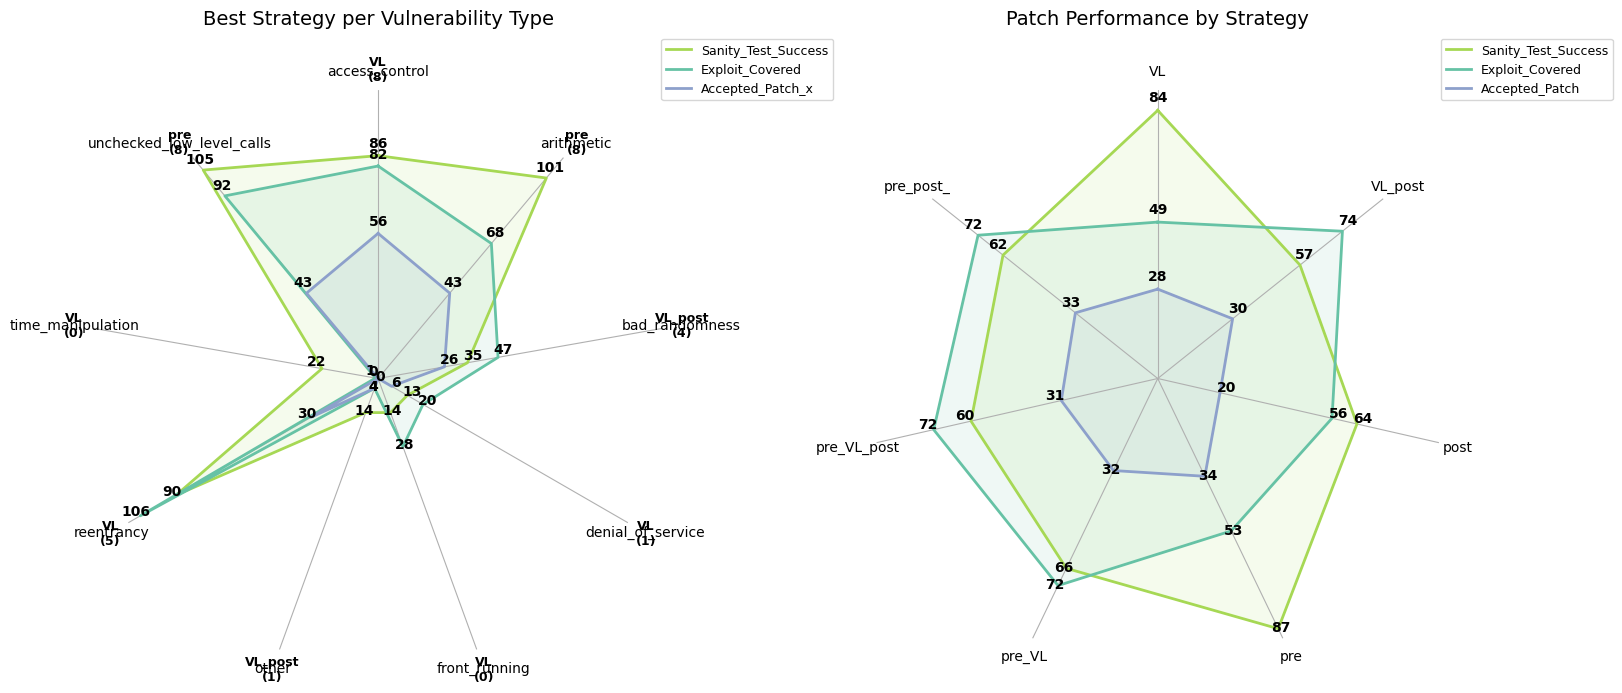

In [20]:
# Augment radar1_grouped to annotate the best patching strategy per vulnerability type
# For each vulnerability type, find the strategy with the highest number of accepted patches

best_strategy_per_vuln = (
    grouped.loc[grouped.groupby("Vulnerability_Type")["Accepted_Patch"].idxmax()]
    [["Vulnerability_Type", "Strategy", "Accepted_Patch"]]
)

# Merge with radar1_grouped to align with plotting order
radar1_enriched = radar1_grouped.merge(best_strategy_per_vuln, on="Vulnerability_Type")

# Function to plot radar chart for vulnerability types with best strategy annotation
def plot_radar_with_best_strategy(ax, labels, data, title, colors):
    N = len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # close the circle

    for i, metric in enumerate(data.columns[1:4]):  # skip label and extra annotation columns
        values = data[metric].tolist()
        values += values[:1]  # close the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=metric, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
        for j, val in enumerate(values[:-1]):
            ax.text(angles[j], val + 2, str(val), ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    # Annotate best strategies near the axis labels
    for i, label in enumerate(labels):
        strategy = data.iloc[i]["Strategy"]
        count = data.iloc[i]["Accepted_Patch_y"]
        angle = angles[i]
        ax.text(angle, ax.get_rmax() + 8, f'{strategy}\n({count})',
                ha='center', va='center', fontsize=9, color='black', fontweight='bold')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])  # remove circular y labels
    ax.set_yticks([])       # remove y-axis layers
    ax.set_title(title, y=1.1, fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.spines["polar"].set_visible(False)

# Re-plot with the left plot modified and right plot kept
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(16, 7))

plot_radar_with_best_strategy(ax1, radar1_enriched["Vulnerability_Type"], radar1_enriched,
                              "Best Strategy per Vulnerability Type", ['#a6d854', '#66c2a5', '#8da0cb'])

plot_radar_multi_clean(ax2, radar2_grouped["Strategy"], radar2_grouped,
                       "Patch Performance by Strategy", ['#a6d854', '#66c2a5', '#8da0cb'])

plt.tight_layout()
plt.show()


In [ ]:
# Improved version: black labels, slightly larger font, no radial layers

def plot_radar_multi_clean(ax, labels, data, title, colors):
    N = len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # close the circle

    for i, metric in enumerate(data.columns[1:]):  # skip label column
        values = data[metric].tolist()
        values += values[:1]  # close the circle
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=metric, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
        for j, val in enumerate(values[:-1]):
            angle_rad = angles[j]
            ax.text(angle_rad, val + 2, str(val), ha='center', va='bottom',
                    fontsize=10, color='black', fontweight='normal')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])  # remove circular y labels
    ax.set_yticks([])       # remove y-axis layers
    ax.set_title(title, y=1.1, fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.spines["polar"].set_visible(False)

# Re-plot with these improvements
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(16, 7))

plot_radar_multi_clean(ax1, radar1_grouped["Vulnerability_Type"], radar1_grouped,
                       "Patch Performance by Vulnerability Type", ['#a6d854', '#66c2a5', '#8da0cb'])

plot_radar_multi_clean(ax2, radar2_grouped["Strategy"], radar2_grouped,
                       "Patch Performance by Strategy", ['#a6d854', '#66c2a5', '#8da0cb'])

plt.tight_layout()
plt.show()


# Question
What is the best way then, to show which one of the patch generation strategies generate the most accepted_patches (perhaps something to integrate in the left plot;)

## Answer: 
We take the patching strategy that generates most accepted patches for each vulnerability type and put it on the axis of that vulnerability type (at the end of the axis above where the vulnerability type label sits) with its contributing number to accepted_patches.  

In [ ]:
# Radar 1: Aggregated by Vulnerability_Type
radar1_grouped = grouped.groupby("Vulnerability_Type")[["Sanity_Test_Success", "Exploit_Covered", "Accepted_Patch"]].sum().reset_index()

# Radar 2: Aggregated by Strategy
radar2_grouped = grouped.groupby("Strategy")[["Sanity_Test_Success", "Exploit_Covered", "Accepted_Patch"]].sum().reset_index()

# Adjusted function to move strategy annotations further from the axis labels
def plot_radar_with_best_strategy_offset(ax, labels, data, title, colors):
    N = len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # close the circle

    for i, metric in enumerate(data.columns[1:4]):  # Sanity, Exploit, Accepted
        values = data[metric].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=metric, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
        for j, val in enumerate(values[:-1]):
            ax.text(angles[j], val + 2, str(val), ha='center', va='bottom',
                    fontsize=10, color='black', fontweight='bold')

    # Adjusted annotation distance for best strategy
    max_radius = max(data[["Sanity_Test_Success", "Exploit_Covered", "Accepted_Patch_x"]].max())
    label_distance = max_radius + 18  # push it further out
    for i, label in enumerate(labels):
        strategy = data.iloc[i]["Strategy"]
        count = data.iloc[i]["Accepted_Patch_y"]
        angle = angles[i]
        ax.text(angle, label_distance, f'{strategy}\n({count})',
                ha='center', va='center', fontsize=9, color='black', fontweight='bold')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])  # no radial layers
    ax.set_yticks([])
    ax.set_title(title, y=1.1, fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.spines["polar"].set_visible(False)

# Re-plot with offset improvement
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(16, 7))

plot_radar_with_best_strategy_offset(ax1, radar1_enriched["Vulnerability_Type"], radar1_enriched,
                                     "Best Strategy per Vulnerability Type", ['#a6d854', '#66c2a5', '#8da0cb'])

plot_radar_multi_clean(ax2, radar2_grouped["Strategy"], radar2_grouped,
                       "Patch Performance by Strategy", ['#a6d854', '#66c2a5', '#8da0cb'])

plt.tight_layout()
plt.show()


In [ ]:
# Adjusted function to move strategy annotations further from the axis labels
def plot_radar_with_best_strategy_offset(ax, labels, data, title, colors):
    N = len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # close the circle

    for i, metric in enumerate(data.columns[1:4]):  # Sanity, Exploit, Accepted
        values = data[metric].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=metric, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
        for j, val in enumerate(values[:-1]):
            ax.text(angles[j], val + 2, str(val), ha='center', va='bottom',
                    fontsize=10, color='black', fontweight='normal')

    # Adjusted annotation distance for best strategy
    max_radius = max(data[["Sanity_Test_Success", "Exploit_Covered", "Accepted_Patch_x"]].max())
    label_distance = max_radius + 18  # push it further out
    
    custom_offsets = [23, 24, 43, 32, 23, 23, 31, -18, 28]  

    for i, label in enumerate(labels):
        strategy = data.iloc[i]["Strategy"]
        count = data.iloc[i]["Accepted_Patch_y"]
        angle = angles[i]
        offset = custom_offsets[i] + max_radius # use per-axis offset
        ax.text(angle, offset, f'{strategy}\n({count})',
                ha='center', va='center', fontsize=9, color='black', fontweight='bold')


    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])  # no radial layers
    ax.set_yticks([])
    ax.set_title(title, y=1.1, fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.spines["polar"].set_visible(False)

# Re-plot with offset improvement
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(polar=True), figsize=(16, 7))

plot_radar_with_best_strategy_offset(ax1, radar1_enriched["Vulnerability_Type"], radar1_enriched,
                                     "Best Strategy per Vulnerability Type", ['#a6d854', '#66c2a5', '#8da0cb'])

plot_radar_multi_clean(ax2, radar2_grouped["Strategy"], radar2_grouped, "Patch Performance by Strategy", ['#a6d854', '#66c2a5', '#8da0cb'])

plt.tight_layout()
plt.show()


In [19]:
# Re-define the plotting functions in this session

from math import pi

# Clean radar chart for multiple metrics with values annotated
def plot_radar_multi_clean(ax, labels, data, title, colors):
    N = len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    for i, metric in enumerate(data.columns[1:]):  # skip label column
        values = data[metric].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=metric, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
        for j, val in enumerate(values[:-1]):
            ax.text(angles[j], val + 2, str(val), ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_title(title, y=1.1, fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.spines["polar"].set_visible(False)

# Radar chart with per-axis offset annotations for best strategy
def plot_radar_with_best_strategy_offset(ax, labels, data, title, colors):
    N = len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    for i, metric in enumerate(data.columns[1:4]):  # Sanity, Exploit, Accepted
        values = data[metric].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=metric, color=colors[i])
        ax.fill(angles, values, alpha=0.1, color=colors[i])
        for j, val in enumerate(values[:-1]):
            ax.text(angles[j], val + 2, str(val), ha='center', va='bottom', fontsize=10, color='black', fontweight='normal')

    # Custom offsets for each axis
    max_radius = max(data[["Sanity_Test_Success", "Exploit_Covered", "Accepted_Patch_x"]].max())
    custom_offsets = [23, 24, 43, 32, 23, 23, 31, -18, 28]  # Adjusted per axis

    for i, label in enumerate(labels):
        strategy = data.iloc[i]["Strategy"]
        count = data.iloc[i]["Accepted_Patch_y"]
        angle = angles[i]
        offset = custom_offsets[i] + max_radius
        ax.text(angle, offset, f'{strategy}\n({count})', ha='center', va='center', fontsize=9, color='black', fontweight='bold')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_title(title, y=1.1, fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
    ax.spines["polar"].set_visible(False)

# Now generate and save the two figures
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(subplot_kw=dict(polar=True), figsize=(8, 7))
plot_radar_with_best_strategy_offset(
    ax1,
    radar1_enriched["Vulnerability_Type"],
    radar1_enriched,
    "Best Strategy per Vulnerability Type",
    ['#a6d854', '#66c2a5', '#8da0cb']
)
fig1.tight_layout()
fig1_path = "figures/radar_best_strategy_per_vuln.pdf"
fig1.savefig(fig1_path, format="pdf")
plt.close(fig1)

fig2, ax2 = plt.subplots(subplot_kw=dict(polar=True), figsize=(8, 7))
plot_radar_multi_clean(
    ax2,
    radar2_grouped["Strategy"],
    radar2_grouped,
    "Patch Performance by Strategy",
    ['#a6d854', '#66c2a5', '#8da0cb']
)
fig2.tight_layout()
fig2_path = "figures/radar_patch_performance_by_strategy.pdf"
fig2.savefig(fig2_path, format="pdf")
plt.close(fig2)

fig1_path, fig2_path


('figures/radar_best_strategy_per_vuln.pdf',
 'figures/radar_patch_performance_by_strategy.pdf')